In [106]:
import numpy as np
import pylab as pl
import scipy.signal.signaltools as sigtool
import scipy.signal as signal
from numpy.random import sample
import random

#the following variables setup the system
Fc = 1000       #simulate a carrier frequency of 1kHz
Fbit = 50       #simulated bitrate of data
Fdev = 500      #frequency deviation, make higher than bitrate
N = 300          #how many bits to send
A = 1           #transmitted signal amplitude
Fs = 5000      #sampling frequency for the simulator, must be higher than twice the carrier frequency
A_n = 0.1#noise peak amplitude
N_prntbits = 10 #number of bits to print in plots

def plot_data(y):
    #view the data in time and frequency domain
    #calculate the frequency domain for viewing purposes
    N_FFT = float(len(y))
    f = np.arange(0,Fs/2,Fs/N_FFT)
    w = np.hanning(len(y))
    y_f = np.fft.fft(np.multiply(y,w))
    y_f = 10*np.log10(np.abs(y_f[0:int(N_FFT/2)]/N_FFT))
    pl.subplot(3,1,1)
    pl.plot(t[0:Fs*N_prntbits/Fbit],m[0:Fs*N_prntbits/Fbit])
    pl.xlabel('Time (s)')
    pl.ylabel('Frequency (Hz)')
    pl.title('Original VCO output versus time')
    pl.grid(True)
    pl.subplot(3,1,2)
    pl.plot(t[0:Fs*N_prntbits/Fbit],y[0:Fs*N_prntbits/Fbit])
    pl.xlabel('Time (s)')
    pl.ylabel('Amplitude (V)')
    pl.title('Amplitude of carrier versus time')
    pl.grid(True)
    pl.subplot(3,1,3)
    pl.plot(f[0:(Fc+Fdev*2)*int(N_FFT/Fs)],y_f[0:(Fc+Fdev*2)*int(N_FFT/Fs)])
    pl.xlabel('Frequency (Hz)')
    pl.ylabel('Amplitude (dB)')
    pl.title('Spectrum')
    pl.grid(True)
    pl.tight_layout()
    pl.show()
    


In [107]:
"""
Data in
"""
#generate some random data for testing
data_in = np.array([random.randint (0,1) for n in range(N)])
# data_in = np.random.random_integers(0,1,N)
data_in.shape

(300,)

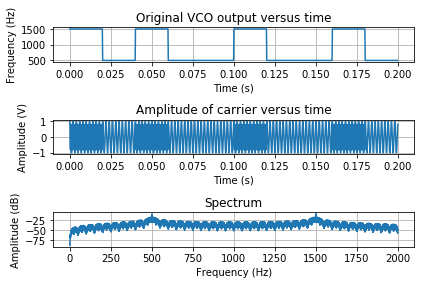

In [108]:
"""
VCO
"""
# one second of data 
t = np.arange(0,float(N)/float(Fbit),1/float(Fs), dtype=np.float)

#extend the data_in to account for the bitrate and convert 0/1 to frequency
m = np.zeros(0).astype(float)
# print(Fc-Fdev)
for bit in data_in:
    if bit == 0:
        m=np.hstack((m,np.multiply(np.ones(int(Fs/Fbit)),Fc+Fdev).astype(float)))
    else:
        m=np.hstack((m,np.multiply(np.ones(int(Fs/Fbit)),Fc-Fdev).astype(float)))

# #calculate the output of the VCO
y=np.zeros(0)
y=A * np.cos(2*np.pi*np.multiply(m,t))
# y.shape
# plot(y, t)
plot_data(y)

In [109]:
# pl.close()

SNR = 13.988577dB


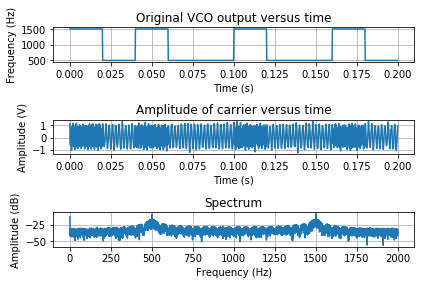

In [110]:
"""
Noisy Channel
"""

#create some noise
noise = (np.random.randn(len(y))+1)*A_n
snr = 10*np.log10(np.mean(np.square(y)) / np.mean(np.square(noise)))
print "SNR = %fdB" % snr
y=np.add(y,noise)
#view the data after adding noise
plot_data(y)

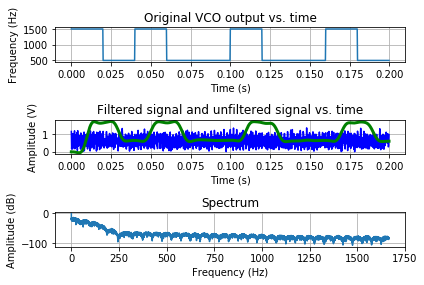

In [111]:
"""
Differentiator
"""
y_diff = np.diff(y,1)

"""
Envelope detector + low-pass filter
"""
#create an envelope detector and then low-pass filter
y_env = np.abs(sigtool.hilbert(y_diff))
h=signal.firwin( numtaps=100, cutoff=Fbit*2, nyq=Fs/2)
y_filtered=signal.lfilter( h, 1.0, y_env)
#view the data after adding noise
N_FFT = float(len(y_filtered))
f = np.arange(0,Fs/2,Fs/N_FFT)
w = np.hanning(len(y_filtered))
y_f = np.fft.fft(np.multiply(y_filtered,w))
y_f = 10*np.log10(np.abs(y_f[0:int(N_FFT/2)]/N_FFT))
pl.subplot(3,1,1)
pl.plot(t[0:Fs*N_prntbits/Fbit],m[0:Fs*N_prntbits/Fbit])
pl.xlabel('Time (s)')
pl.ylabel('Frequency (Hz)')
pl.title('Original VCO output vs. time')
pl.grid(True)
pl.subplot(3,1,2)
pl.plot(t[0:Fs*N_prntbits/Fbit],np.abs(y[0:Fs*N_prntbits/Fbit]),'b')
pl.plot(t[0:Fs*N_prntbits/Fbit],y_filtered[0:Fs*N_prntbits/Fbit],'g',linewidth=3.0)
pl.xlabel('Time (s)')
pl.ylabel('Amplitude (V)')
pl.title('Filtered signal and unfiltered signal vs. time')
pl.grid(True)
pl.subplot(3,1,3)
pl.plot(f[0:(Fc+Fdev*2)*int(N_FFT/Fs)],y_f[0:(Fc+Fdev*2)*int(N_FFT/Fs)])
pl.xlabel('Frequency (Hz)')
pl.ylabel('Amplitude (dB)')
pl.title('Spectrum')
pl.grid(True)
pl.tight_layout()
pl.show()

In [112]:
"""
slicer
"""
#calculate the mean of the signal
mean = np.mean(y_filtered)
#if the mean of the bit period is higher than the mean, the data is a 0
rx_data = []
sampled_signal = y_filtered[Fs/Fbit/2:len(y_filtered):Fs/Fbit]
for bit in sampled_signal:
    if bit > mean:
        rx_data.append(0)
    else:
        rx_data.append(1)

bit_error=0
for i in range(0,len(data_in)):
    if(rx_data[i] != data_in[i]):
        bit_error = bit_error +  1
print "bit errors = %d" % bit_error
print "bit error percent = %4.2f%%" % (float(bit_error)/float(N)*100)

bit errors = 21
bit error percent = 7.00%
